# Solving Ricochet Robot

See https://en.wikipedia.org/wiki/Ricochet_Robot for more info

In [130]:
# %matplotlib inline
import matplotlib.pyplot as plt

In [176]:
DIMENSION = 16 # size of the board
UP, DOWN, LEFT, RIGHT = range(4) # directional enum
DIRX = [0, 0, -1, 1] # directional vectors
DIRY = [1, -1, 0, 0] # color vectors
COLORS = ['red','blue','green','purple']

def normalize_wall(x, y, direction):
    'walls are normalized to "down" or "left"'
    if direction == UP:
        direction = DOWN
        y += 1
    elif direction == RIGHT:
        direction = LEFT
        x += 1
    return (x, y, direction)

def compute_delta(robots1, robots2):
    # delta between two position
    # return (color, (x, y), (x, y))
    for idx in range(len(COLORS)):
        if robots1[idx] != robots2[idx]:
            return (idx, robots1[idx], robots2[idx])

class Board(object):
    def __init__(self):
        # bottom left of grid is 0, 0
        self.walls = set() # list of walls - (x, y, (DOWN|LEFT))
        
    def add_wall(self, x, y, direction):
        """Add a wall to the current position"""
        self.walls.add(normalize_wall(x, y, direction))
        
    def has_wall(self, x, y, direction):
        """Determine whether there's a wall in the given position."""
        return normalize_wall(x, y, direction) in self.walls
        
    def next_moves(self, robots):
        """Generate list of next moves."""
        def generate(index, replaced_robot):
            return tuple((replaced_robot if i == index else robot) for (i, robot) in enumerate(robots))
        for index, robot in enumerate(robots):
            for direction in range(len(COLORS)):
                (x, y) = robot
                moved = False
                while True:
                    newx = x + DIRX[direction]
                    newy = y + DIRY[direction]
                    if self.has_wall(x, y, direction) or (newx, newy) in robots:
                        if moved:
                            yield generate(index, (x, y))
                        break
                    else:
                        moved = True
                        x = newx
                        y = newy

In [197]:
import heapq

MAX_DEPTH = 30

class Stat(object):
    def __init__(self):
        self.iteration = 0
        self.distance = -1
        
    def __repr__(self):
        return repr(self.__dict__)
        
def astar(board, start, finish_condition, heuristic=None, stat=None):
    # finish_condition = (color, (x, y))
    queue = [] # contains (distance+heuristic, distance, position)
    heapq.heappush(queue, (0, 0, start, None))
    history = {} # position -> (distance, previous)
    finish_color, finish_position = finish_condition
    if not stat:
        stat = Stat()
    if not heuristic:
        heuristic = lambda new, old: 0
    while queue:
        stat.iteration += 1
        _, distance, position, prev_position = heapq.heappop(queue)
        if distance > MAX_DEPTH:
            return
        if finish_position == position[finish_color]:
            positions = [position, prev_position]
            cur_position = prev_position
            while cur_position in history:
                cur_position = history[cur_position][1]
                if cur_position is not None:
                    positions.append(cur_position)
            stat.distance = distance
            return positions
        if position in history:
            continue
        else:
            history[position] = (distance, prev_position)
        new_distance = distance + 1
        for new_position in board.next_moves(position):
            heapq.heappush(queue, (new_distance + heuristic(position, new_position), new_distance, new_position, position))

In [193]:
def print_board(board, robots,
                paths=None,
                additionals=None,
                draw_grid=False,
                finish=None):
    '''
    Print the given board position.
    robots - 4-tuple of pair (x, y), representing red, blue, green, and yellow robots.
    paths - list of (color, (x, y), (x, y)) paths to draw.
    additionals - list of (color, (x, y)) points to draw.
    '''
    plt.figure(figsize=(5, 5))
    margin = 0.1
    PADDING = 0.5
    if draw_grid:
        for row in range(DIMENSION):
            for col in range(DIMENSION):
                rectangle = plt.Rectangle((row + margin, col + margin),
                                          1 - margin * 2,
                                          1 - margin * 2,
                                          fc='#eeefff')
                plt.gca().add_patch(rectangle)
    def plot_robot(index, coord, size):
        (x, y) = coord
        circle = plt.Circle((x + 0.5, y + 0.5), size, fc=COLORS[i])
        plt.gca().add_patch(circle)
        
    for wall in board.walls:
        (x1, y1, direction) = wall
        if direction == DOWN:
            x2 = x1 + 1
            y2 = y1
        else:
            x2 = x1
            y2 = y1 + 1
        line = plt.Line2D((x1, x2), (y1, y2), lw=2.5, color='black')
        plt.gca().add_line(line)
    for path in (paths or []):
        (i, pos1, pos2) = path
        line = plt.Line2D((pos1[0] + 0.5, pos2[0] + 0.5), (pos1[1] + 0.5, pos2[1] + 0.5), color=COLORS[i],
                         marker='x')
        plt.gca().add_line(line)
    for additional in (additionals or []):
        (i, robot) = additional
        plot_robot(i, robot, 0.1)
    if finish is not None:
        (i, coord) = finish
        (row, col) = coord
        rectangle = plt.Rectangle((row + margin, col + margin),
                                  1 - margin * 2,
                                  1 - margin * 2,
                                  fc=COLORS[i])
        plt.gca().add_patch(rectangle)
        
    plt.xlim(0 - PADDING, 16 + PADDING)
    plt.ylim(0 - PADDING, 16 + PADDING)
    for i in range(len(COLORS)):
        plot_robot(i, robots[i], 0.4)
    plt.show()

In [194]:
# sample board
# TODO - randomly generate this
# got idea from http://1.bp.blogspot.com/-Ythx5IaMAxY/UPrGdgymTUI/AAAAAAAAHzY/3qHS2Hp9tkw/s1600/006-Ricochet+Robot.JPG
board = Board()
for i in range(16):
    board.add_wall(0, i, LEFT)
    board.add_wall(i, 0, DOWN)
    board.add_wall(16, i, LEFT)
    board.add_wall(i, 16, DOWN)
board.add_wall(0, 5, DOWN)
board.add_wall(0, 9, DOWN)
board.add_wall(1, 12, RIGHT)
board.add_wall(1, 12, UP)
board.add_wall(1, 2, DOWN)
board.add_wall(1, 2, LEFT)
board.add_wall(10, 15, LEFT)
board.add_wall(10, 8, RIGHT)
board.add_wall(10, 8, UP)
board.add_wall(11, 1, DOWN)
board.add_wall(11, 1, RIGHT)
board.add_wall(11, 13, DOWN)
board.add_wall(11, 13, LEFT)
board.add_wall(12, 6, RIGHT)
board.add_wall(12, 6, UP)
board.add_wall(13, 9, DOWN)
board.add_wall(13, 9, RIGHT)
board.add_wall(14, 0, LEFT)
board.add_wall(14, 14, LEFT)
board.add_wall(14, 14, UP)
board.add_wall(14, 2, DOWN)
board.add_wall(14, 2, LEFT)
board.add_wall(15, 12, DOWN)
board.add_wall(15, 6, DOWN)
board.add_wall(2, 10, DOWN)
board.add_wall(2, 10, RIGHT)
board.add_wall(3, 6, DOWN)
board.add_wall(3, 6, RIGHT)
board.add_wall(4, 15, LEFT)
board.add_wall(5, 0, LEFT)
board.add_wall(5, 11, LEFT)
board.add_wall(5, 11, UP)
board.add_wall(5, 4, LEFT)
board.add_wall(5, 4, UP)
board.add_wall(6, 1, RIGHT)
board.add_wall(6, 1, UP)
board.add_wall(6, 14, DOWN)
board.add_wall(6, 14, LEFT)
board.add_wall(7, 10, DOWN)
board.add_wall(7, 10, RIGHT)
board.add_wall(9, 3, LEFT)
board.add_wall(9, 3, UP)
# center piece
board.add_wall(7, 7, LEFT)
board.add_wall(7, 7, DOWN)
board.add_wall(7, 8, LEFT)
board.add_wall(7, 8, UP)
board.add_wall(8, 7, RIGHT)
board.add_wall(8, 7, DOWN)
board.add_wall(8, 8, RIGHT)
board.add_wall(8, 8, UP)
robots = ((0, 1), (4, 1), (7, 14), (12, 4))

In [212]:
def run_and_plot(finish, heuristic=None):
    stat = Stat()
    deltas = set()
    positions = astar(board, robots, finish, heuristic=heuristic, stat=stat)
    if positions is not None:
        for i in range(len(positions) - 1):
            deltas.add(compute_delta(positions[i + 1], positions[i]))
    print_board(board, robots, deltas, finish=finish, draw_grid=False)
    return stat

def prefer_moving_main(color, weight=1):
    # note: weight > 1, then inadmissible
    def heuristic(new, old):
        return 0 if (compute_delta(new, old)[0] == color) else weight
    return heuristic

def make_heuristic(coord, board):
    # TODO
    pass

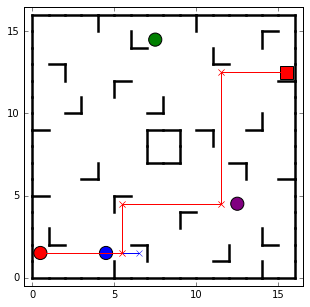

{'distance': 6, 'iteration': 74052}

In [213]:
# Without any heuristic
run_and_plot((0, (15, 12)))

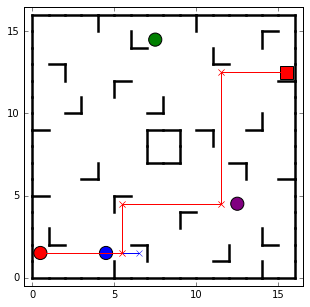

{'distance': 6, 'iteration': 36621}

In [222]:
# with heuristic - reduces # of moves by 1/2
run_and_plot((0, (15, 12)), prefer_moving_main(0))

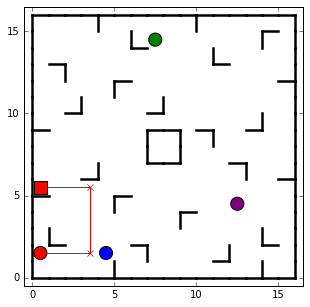

{'distance': 3, 'iteration': 385}

In [224]:
run_and_plot((0, (0, 5)), prefer_moving_main(0))

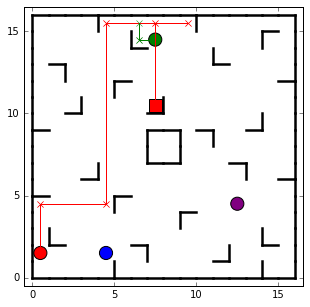

{'distance': 8, 'iteration': 258724}

In [227]:
run_and_plot((0, (7, 10)), prefer_moving_main(0, 1))

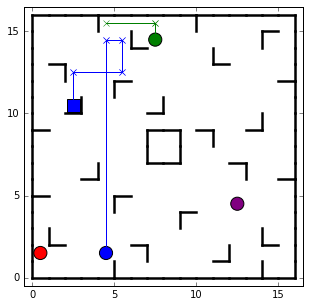

{'distance': 7, 'iteration': 78416}

In [209]:
run_and_plot((1, (2, 10)), prefer_moving_main(1))

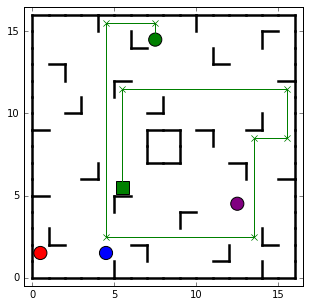

{'distance': 9, 'iteration': 511919}

In [210]:
run_and_plot((2, (5, 5)), prefer_moving_main(2))

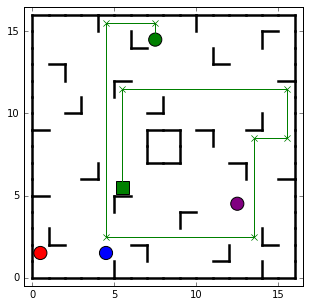

{'distance': 9, 'iteration': 288347}

In [221]:
run_and_plot((2, (5, 5)), prefer_moving_main(2, 2))